In [6]:
import os

# OpenMP 충돌 에러 방지 (Mac M-series 필수 설정)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

model_name = "InstaDeepAI/NTv3_100M_post"

# 1. 'ForMaskedLM' 대신 그냥 'AutoModel' 사용
# (얘는 Config를 안 가리고 주는 대로 다 받아줍니다)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# 2. 디바이스 설정
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)
model.eval()

# 3. 모델 구조 확인 (여기서 Head의 이름을 찾아야 합니다)
print(model) 
# 위 주석을 풀고 실행하면 layer 이름들이 뜹니다. 보통 'lm_head', 'cls', 'head' 중 하나입니다.



NTv3PostTrained(
  (core): NTv3PostTrainedCore(
    (embed_layer): Embedding(11, 16)
    (stem): Stem(
      (conv): Conv1d(16, 768, kernel_size=(15,), stride=(1,), padding=same)
    )
    (conv_tower_blocks): ModuleList(
      (0-6): 7 x ConditionedConvTowerBlock(
        (conv): AdaptiveConvBlock(
          (conv): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=same)
          (layer_norm): AdaptiveLayerNorm(
            (np.int64(768),), eps=1e-05, elementwise_affine=True
            (modulation_layers): ModuleList(
              (0): Linear(in_features=16, out_features=1536, bias=True)
            )
          )
        )
        (res_conv): AdaptiveResidualConvBlock(
          (conv_block): AdaptiveConvBlock(
            (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
            (layer_norm): AdaptiveLayerNorm(
              (np.int64(768),), eps=1e-05, elementwise_affine=True
              (modulation_layers): ModuleList(
                (0): Linear

In [ ]:
import torch
import torch.nn.functional as F

# ... (앞부분 모델 로드 코드는 동일) ...

sequence = "ATGCGTAGCGCGTAGCG<mask>TAGCGCGT"
# 1. 일단 토크나이징
inputs = tokenizer(sequence, return_tensors="pt")

# ---------------------------------------------------------
# 🛠️ [FIX] 패딩 추가 (길이를 128의 배수로 맞춤)
# ---------------------------------------------------------
input_ids = inputs["input_ids"]
seq_len = input_ids.shape[1]

# 목표 길이 계산 (128의 배수 중 현재 길이보다 큰 최소값)
# NTv3는 깊은 구조 때문에 넉넉한 길이(예: 1024 이상)가 성능이 더 좋지만, 
# 일단 최소 동작 조건인 128 배수로 맞춥니다.
target_len = ((seq_len - 1) // 128 + 1) * 128 
pad_len = target_len - seq_len

# 패딩 토큰 ID 가져오기 (보통 tokenizer.pad_token_id가 있지만, 없으면 0이나 4(N) 사용)
pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0

# F.pad를 사용해 뒤쪽에 패딩 붙이기
if pad_len > 0:
    print(f"🔧 Original Len: {seq_len} -> Padding to: {target_len} (+{pad_len})")
    input_ids = F.pad(input_ids, (0, pad_len), value=pad_token_id)

# inputs 딕셔너리 업데이트
inputs["input_ids"] = input_ids.to(device)
if "attention_mask" in inputs:
    # 어텐션 마스크도 패딩 부분은 0으로 채워줘야 함
    att_mask = inputs["attention_mask"]
    att_mask = F.pad(att_mask, (0, pad_len), value=0)
    inputs["attention_mask"] = att_mask.to(device)
# ---------------------------------------------------------

# 2. Species ID 준비 (이전 단계 코드)
try:
    species_map = model.config.species_to_token_id
    target_species = "human" 
    if target_species not in species_map:
        species_id_value = list(species_map.values())[0]
    else:
        species_id_value = species_map[target_species]
except AttributeError:
    species_id_value = 4 

batch_size = input_ids.shape[0]
species_ids = torch.full((batch_size,), species_id_value, dtype=torch.long, device=device)

# 3. 추론 실행
with torch.no_grad():
    # output_hidden_states=True를 줘서 확실하게 hidden state를 받아옵니다.
    outputs = model(**inputs, species_ids=species_ids, output_hidden_states=True)
    
    # Hidden state 추출
    if hasattr(outputs, 'hidden_states'):
        hidden_states = outputs.hidden_states[-1] # 마지막 레이어
    elif hasattr(outputs, 'last_hidden_state'):
        hidden_states = outputs.last_hidden_state
    else:
        # 구조상 hidden_states 튜플의 마지막 요소일 확률 높음
        hidden_states = outputs[0]

    # [중요] 패딩된 부분은 자르고 원래 길이만큼만 가져와서 예측
    # hidden_states: [Batch, Padded_Len, 768]
    valid_hidden_states = hidden_states[:, :seq_len, :]
    
    # Head 통과
    logits = model.core.lm_head.head(valid_hidden_states)

# 4. 마스크 예측
mask_token_index = tokenizer.mask_token_id
# 원래 sequence 길이 안에서 마스크 찾기
mask_positions = (inputs["input_ids"][0][:seq_len] == mask_token_index)

if mask_positions.sum() > 0:
    mask_token_logits = logits[0, mask_positions, :]
    predicted_token_id = torch.argmax(mask_token_logits, dim=-1)
    predicted_base = tokenizer.decode(predicted_token_id)
    print(f"🎉 Predicted base: {predicted_base}")
    
else:
    print("⚠️ 마스크 토큰을 찾을 수 없습니다. (토크나이저 문제일 수 있음)")

🔧 Original Len: 26 -> Padding to: 128 (+102)
🎉 Predicted base: A


🔍 마스크 위치 예측 확률 분포:

 Token  Probability
     A 5.602975e-01
     G 3.541836e-01
     C 4.753530e-02
     T 3.784337e-02
     N 1.403361e-04
 <pad> 1.334800e-23
 <cls> 1.122133e-23
 <unk> 6.601412e-24
 <eos> 5.805073e-24
 <bos> 4.102321e-24
<mask> 4.023404e-24

🧬 [주요 염기 확률 요약]
  A: 0.560297 (56.03%)
  T: 0.037843 (3.78%)
  G: 0.354184 (35.42%)
  C: 0.047535 (4.75%)


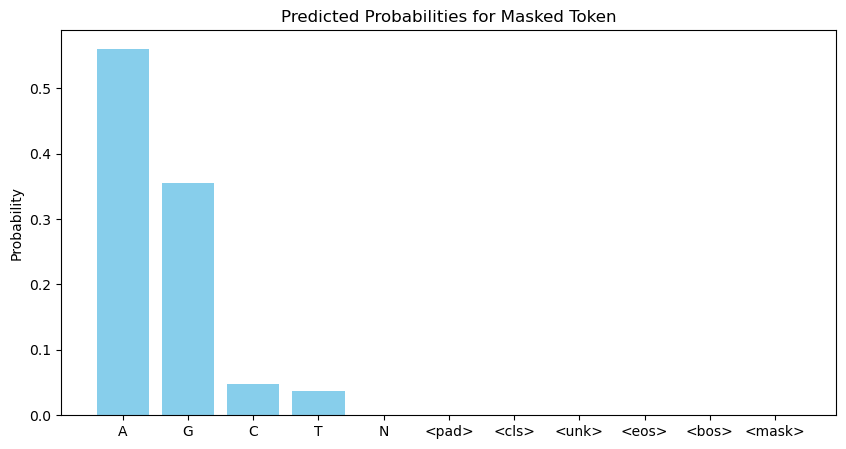

In [9]:
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# [이전 코드의 'logits' 변수가 생성된 상태에서 실행하세요]
# mask_token_logits: (Mask_Count, Vocab_Size) 크기의 텐서라고 가정
# ------------------------------------------------------------------

# 1. Logits을 확률(Probability)로 변환
# dim=-1은 마지막 차원(Vocab)에 대해 합이 1이 되도록 만듭니다.
probs = F.softmax(mask_token_logits, dim=-1) 

# 첫 번째 마스크에 대한 결과만 가져오기 (마스크가 여러 개면 loop 필요)
target_prob = probs[0] 

# 2. 모든 토큰의 확률 가져오기
# NTv3의 Vocab 사이즈는 작음 (약 11~12개: A,T,G,C,N,Pad,Mask...)
all_tokens = []
all_probs = []

for token_id, prob in enumerate(target_prob):
    # 토큰 ID를 문자로 변환 (예: 6 -> 'A')
    token_str = tokenizer.decode([token_id])
    all_tokens.append(token_str)
    all_probs.append(prob.item())

# 3. 데이터프레임으로 깔끔하게 정리
df = pd.DataFrame({
    'Token': all_tokens,
    'Probability': all_probs,
    'Token_ID': range(len(all_tokens))
})

# 확률 높은 순으로 정렬
df_sorted = df.sort_values(by='Probability', ascending=False).reset_index(drop=True)

# ------------------------------------------------------------------
# 🖥️ 결과 출력
# ------------------------------------------------------------------
print(f"🔍 마스크 위치 예측 확률 분포:\n")
print(df_sorted[['Token', 'Probability']].to_string(index=False))

# (옵션) 주요 염기(A, T, G, C)만 따로 보기
major_bases = ['A', 'T', 'G', 'C']
print("\n🧬 [주요 염기 확률 요약]")
for base in major_bases:
    # 데이터프레임에서 해당 염기 찾기
    row = df[df['Token'] == base]
    if not row.empty:
        p = row['Probability'].values[0]
        print(f"  {base}: {p:.6f} ({p*100:.2f}%)")
    else:
        print(f"  {base}: (Vocab에 없음)")

# (옵션) 시각화
plt.figure(figsize=(10, 5))
plt.bar(df_sorted['Token'], df_sorted['Probability'], color='skyblue')
plt.title('Predicted Probabilities for Masked Token')
plt.ylabel('Probability')
plt.show()